<a href="https://colab.research.google.com/github/huerd/GPA659-E2020/blob/howard%2Fmodel/_project/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *Resources*

### Visualisations
*   Kernel Visualizations : https://github.com/raghakot/keras-vis
*   [Tools to design/visualize NN architecture](https://github.com/ashishpatel26/Tools-to-Design-or-Visualize-Architecture-of-Neural-Network)
*   Image Files to Numpy Array : https://www.kaggle.com/lgmoneda/from-image-files-to-numpy-arrays
*   MobileNetV2 Dogs/Cats implementation : https://www.kaggle.com/abdallahhassan/dogs-cats-mobilenetv2-transfere-learning









# Per Runtime Setup [Authorization w/ Kaggle database and download]

1.   Set your Kaggle API .JSON file to this runtime
2.   Downloads and extract dogs-vs-cats.zip into two folders



In [1]:
# updates kaggle version
!pip install pillow==7.0.0 
!pip install --upgrade --force-reinstall --no-deps kaggle


# fix https://github.com/keras-team/keras-preprocessing/issues/116 for datagen
!pip uninstall -y keras-preprocessing
!pip install git+https://github.com/keras-team/keras-preprocessing.git

from google.colab import files
import zipfile

# select your Kaggle API kaggle.json
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# make sure to create a kaggle account, get it verified (phone number and all)
# then go accept terms here : https://www.kaggle.com/c/dogs-vs-cats

# zip should be downloaded to /content/
!kaggle competitions download -c dogs-vs-cats
unzipMaster = zipfile.ZipFile("dogs-vs-cats.zip", 'r')
unzipMaster.extractall()
unzipMaster.close()


# don't expand the folders unless you want colab to crash on you
# file format is 1.jpg, 2.jpg, etc
unzipTest1 = zipfile.ZipFile("test1.zip", 'r')
unzipTest1.extractall()
unzipTest1.close()

# file format is cat.0.jpg, dog.2.jpg, etc
unzipTrain1 = zipfile.ZipFile("train.zip", 'r')
unzipTrain1.extractall()
unzipTrain1.close()

     |████████████████████████████████| 61kB 2.6MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=1a06d8c1f4f3460404b694b061e07311696321ca52fcefd72bf212e73ebca45f
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-xz9mg01n
  Running command git clone -q https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-xz9mg01n
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.2-cp36-none-any.whl size=42983 sha256=ed608ea6af9110726cd26b9075a15954c2f2c60c9c13046192ff2511fec9a82e
  Stored in directory: /tmp/pip-ephem-wheel-cache-royuzuvf/wheels

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes
 97% 790M/812M [00:03<00:00, 258MB/s]
100% 812M/812M [00:04<00:00, 207MB/s]


# Dev Environment Setup

In [16]:
from __future__ import print_function

# uncomment below to use version 1.x
#%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from scipy import ndimage
import matplotlib.pyplot as plt
import pandas
import numpy
import os, sys
import IPython.display
import PIL.Image
import random

## Constants

In [29]:
IMAGE_WIDTH = 150
IMAGE_LENGTH = 150
IMAGE_SIZE = [IMAGE_WIDTH, IMAGE_LENGTH]
IMAGE_NUMCHANNELS = 3

TRAININGDATASPLIT_RATIO = 0.9
BATCH_SIZE = 16
SEED = 4

QUICK_TRAIN = True
EPOCH_QUICK = 3
EPOCH_NORMAL = 50


# Data Loading

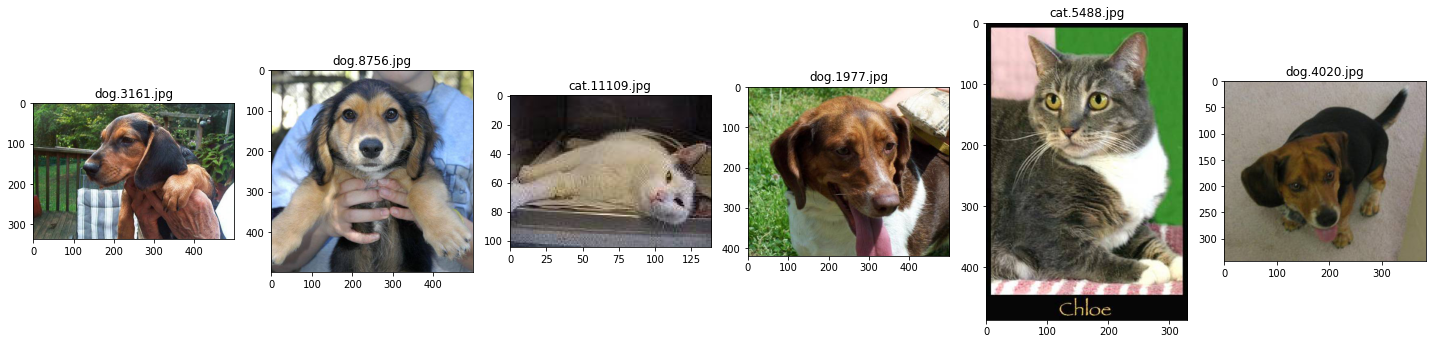

Total Counts from Labeled Data


cat    12500
dog    12500
Name: petType, dtype: int64

In [30]:
trainingData_dir = "train/"
testingData_dir = "test1/"

# load data
labeledDataset = os.listdir(trainingData_dir)
testingDataset = os.listdir(testingData_dir)

results = []

# loop through our labeledDataset, one file at a time
for eachImage in labeledDataset:
  # recall that our labeledDataset file format is [animal].[num].jpg
  petType = eachImage.split('.')[0]
  if petType == 'cat':
    results.append("cat")
  else:
    results.append("dog")

# df_labeled is where all our labeled data is stored in a DataFrame
df_labeled = pandas.DataFrame({
    'imageName': labeledDataset,
    'petType': results
})

## Visualizations
# create figure size
plt.figure(figsize=(20, 12))
for i in range(0, 6):
    plt.subplot(1, 6, i+1)
    imageName = random.choice(labeledDataset)
    image = load_img(trainingData_dir + imageName)
    plt.title(imageName)
    plt.imshow(image)
plt.tight_layout()
plt.show()

print("Total Counts from Labeled Data")
df_labeled['petType'].value_counts()

## Splitting training dataset into Training and Validation sets

In [31]:
from sklearn.model_selection import train_test_split

# split your labeled dataset into training and validation sets based on a ratio
# if train_size is 0.3, then training is 70% of the dataset
df_training, df_validation = train_test_split(df_labeled, train_size = TRAININGDATASPLIT_RATIO)

# pandas.DataFrame.shape is a tuple
# https://www.programiz.com/python-programming/methods/tuple
total_dfTraining = df_training.shape[0]
total_dfValidation = df_validation.shape[0]


print("Labeled Data Allocation")
fmt = '{:<4} {:<2} {:<15} '
print(fmt.format("Train :", "", total_dfTraining))
print(fmt.format("Valid :", "", total_dfValidation))

# ref https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main1.ipynb

Labeled Data Allocation
Train :    22500           
Valid :    2500            


### Preprocessing

Check [ImageDataGenerator] Reference : https://keras.io/api/preprocessing/image/
Its purpose : Used for Data Augmentation - takes the original image, applies a bunch of transforms to the original. The class doesn't change.

*   https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
*   https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb

*   [In-depth on Data Augmentation](https://medium.com/mlait/image-data-augmentation-image-processing-in-tensorflow-part-2-b77237256df0)




Found 22500 validated image filenames belonging to 2 classes.
Visualized Example of Generator.


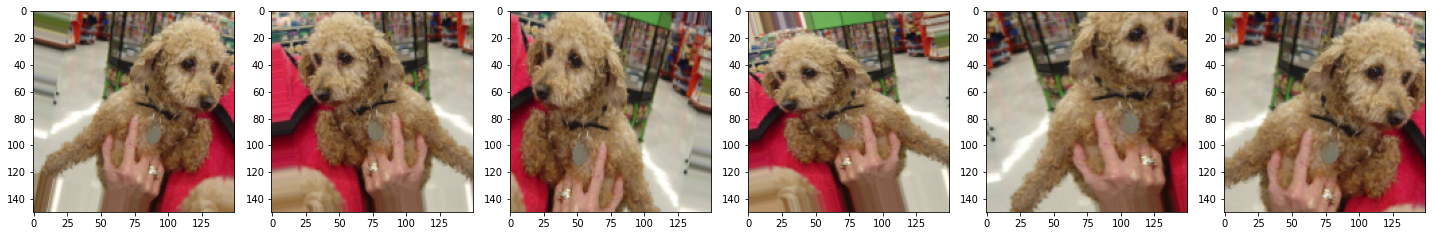

In [32]:
# playing around here I guess
dg_training = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip= True,
    fill_mode = 'nearest',
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

# Returns 
# A DataFrameIterator yielding tuples of (x, y) where x is a numpy array 
# containing a batch of images with shape (batch_size, *target_size, channels) 
# and y is a numpy array of corresponding labels.

train_generator = dg_training.flow_from_dataframe(
    df_training, 
    directory = trainingData_dir, 
    x_col = 'imageName',
    y_col = 'petType',
    # class_mode = 'binary',
    class_mode = 'categorical',
    target_size = (IMAGE_WIDTH, IMAGE_LENGTH),
    batch_size = BATCH_SIZE,
    seed = SEED
)

print("Visualized Example of Generator.")
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 6, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# TODO have it return random images
augmented_images = [train_generator[0][0][0] for i in range(6)]
plotImages(augmented_images)

*  [Image Classification using data generators](https://mc.ai/tutorial-image-classification-with-keras-flow_from_directory-and-generators/)

Found 2500 validated image filenames belonging to 2 classes.
Visualized Example of Generator.


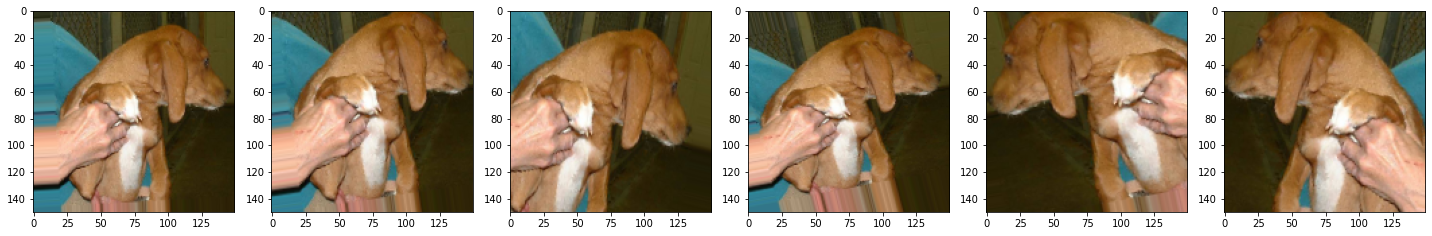

In [33]:
# same stuff but for validation data
# playing around here I guess
dg_validation = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip= True,
    fill_mode = 'nearest',
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

# Returns 
# A DataFrameIterator yielding tuples of (x, y) where x is a numpy array 
# containing a batch of images with shape (batch_size, *target_size, channels) 
# and y is a numpy array of corresponding labels.

valid_generator = dg_validation.flow_from_dataframe(
    df_validation, 
    directory = trainingData_dir, 
    x_col = 'imageName',
    y_col = 'petType',
    # class_mode = 'binary',
    class_mode = 'categorical',
    target_size = (IMAGE_WIDTH, IMAGE_LENGTH),
    batch_size = BATCH_SIZE,
    seed = SEED
)

print("Visualized Example of Generator.")
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 6, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# TODO have it return random images
augmented_images = [valid_generator[0][0][0] for i in range(6)]
plotImages(augmented_images)

## Test Data (TODO)

# Model Architecture


*   [MobileNet from scratch](https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main2.ipynb)

In [34]:
# mobile = keras.applications.mobilenet.MobileNet()

# TODO : THIS IS JUST A COPY PASTE from the link above. Might have to adjust/change

def mobilenet(input_shape, n_classes):
  
  # TODO modify this to include pointwise
  # maybe use this ? https://keras.io/api/layers/convolution_layers/separable_convolution2d/
  def mobilenet_block(x, f, s=1):
    x = DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(f, 1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
    
    
  input = Input(input_shape)

  x = Conv2D(32, 3, strides=2, padding='same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 128, 2)
  x = mobilenet_block(x, 128)

  x = mobilenet_block(x, 256, 2)
  x = mobilenet_block(x, 256)

  x = mobilenet_block(x, 512, 2)
  for _ in range(5):
    x = mobilenet_block(x, 512)

  x = mobilenet_block(x, 1024, 2)
  x = mobilenet_block(x, 1024)
  
  x = GlobalAvgPool2D()(x)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model



In [35]:


# Overfitting setup
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)

# learning rate change after accuracy stalls
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]


## Model Summary

In [36]:
input_shape=(IMAGE_WIDTH, IMAGE_LENGTH, IMAGE_NUMCHANNELS);
n_classes = 2;
model = mobilenet(input_shape, n_classes);
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization_55 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
re_lu_55 (ReLU)              (None, 75, 75, 32)        0         
_________________________________________________________________
depthwise_conv2d_27 (Depthwi (None, 75, 75, 32)        320       
_________________________________________________________________
batch_normalization_56 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
re_lu_56 (ReLU)              (None, 75, 75, 32)        0   

## Model Visualization

*   Architecture Visualization : https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main4.ipynb

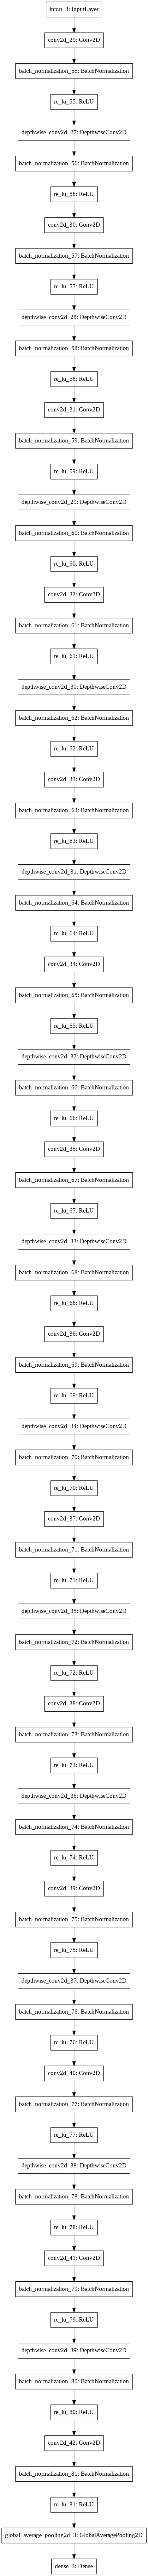

In [37]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

plot_model(model,rankdir='TB')

# SVG(model_to_dot(model).create(prog='dot', format='svg'))
# def svg_to_fixed_width_html_image(svg, width="100%"):
#     text = _html_template.format(width, base64.b64encode(svg))
#     return HTML(text)

# svg_to_fixed_width_html_image(output)

# Start model training

In [38]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

epochs = EPOCH_QUICK if QUICK_TRAIN else EPOCH_NORMAL

# depreciated and should change to Model.fit if possible
history = model.fit_generator(
    train_generator, 
    epochs = epochs,
    validation_data = valid_generator,
    validation_steps =  total_dfValidation // BATCH_SIZE,
    steps_per_epoch = total_dfValidation // BATCH_SIZE,
    callbacks = callbacks
)

Epoch 1/3
156/156 [==============================] - 371s 2s/step - loss: 0.8209 - acc: 0.5381 - val_loss: 0.5954 - val_acc: 0.5080
Epoch 2/3
156/156 [==============================] - 372s 2s/step - loss: 0.7122 - acc: 0.5757 - val_loss: 0.8300 - val_acc: 0.5081
Epoch 3/3
156/156 [==============================] - 360s 2s/step - loss: 0.6875 - acc: 0.5938 - val_loss: 0.7236 - val_acc: 0.5081

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


# Model Accuracy and Loss graphs

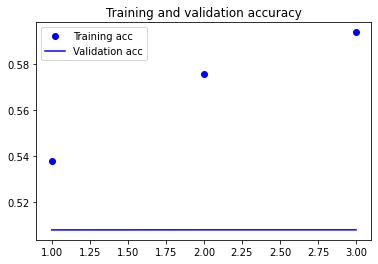

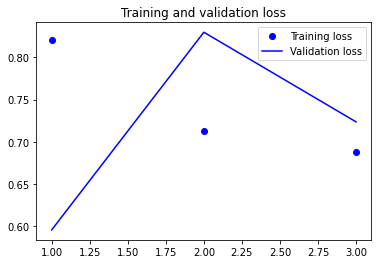

In [89]:

# ref  : https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main2.ipynb

# this is outdated. revert to model.evaluate if possible
# loss, accuracy = model.evaluate_generator(valid_generator, 
#                                           total_dfValidation // BATCH_SIZE, 
#                                           workers=12, 
#                                           use_multiprocessing = True)
# print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))



# def plot_model_history(model_history, accuracy='acc', val_accuracy='val_acc'):
#     fig, axs = plt.subplots(1,2,figsize=(20,20))
#     axs[0].plot(range(1,len(model_history.history[accuracy])+1),model_history.history[accuracy])
#     axs[0].plot(range(1,len(model_history.history[val_accuracy])+1),model_history.history[val_accuracy])
#     axs[0].set_title('Model Accuracy')
#     axs[0].set_ylabel('Accuracy')
#     axs[0].set_xlabel('Epoch')
#     axs[0].set_xticks(numpy.arange(1,len(model_history.history[accuracy])+1),len(model_history.history[accuracy])/10)
#     axs[0].legend(['train', 'val'], loc='best')
#     axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
#     axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
#     axs[1].set_title('Model Loss')
#     axs[1].set_ylabel('Loss')
#     axs[1].set_xlabel('Epoch')
#     axs[1].set_xticks(numpy.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
#     axs[1].legend(['train', 'val'], loc='best')
#     plt.show()
    
# plot_model_history(history)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()



# Layer Visualizations

TypeError: ignored

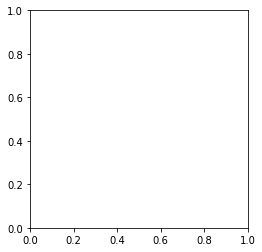

In [85]:
import cv2
# imageName = random.choice(testingDataset)
# testImage = load_img(testingData_dir + imageName)
# testImage = numpy.reshape(testImage, (150, 150))

testImage = train_generator[0][0][0] 

# testImage = cv2.imread(testingData_dir + imageName)
# plt.imshow(testImage)
# use the np.resize function to solve that. I apologise for the late response. But use np.resize(img, (-1, <image shape>)
# testImage = cv2.resize(testImage, (150,150))


# here we get rid of that added dimension and plot the image
def visualize_cat(model, test):
    # Keras expects batches of images, so we have to add a dimension to trick it into being nice
    test_batch = numpy.expand_dims(test,axis=0)
    conv_test = model.predict(test_batch)
    conv_test = numpy.squeeze(conv_test, axis=0)
    plt.imshow(conv_test)

test_batch = numpy.expand_dims(testImage,axis=0)
conv_test = model.predict(test_batch)


visualize_cat(model, testImage)

# Confusion Matrix